In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize, LinearSegmentedColormap
import matplotlib.colors as colors
import scipy.stats as stats
from netCDF4 import Dataset
from scipy.stats import pearsonr
import wrf
import sys

from mmctools.plotting import TaylorDiagram
from mmctools.helper_functions import theta_to_T, lowess_mean, calc_uv, calc_wind, w_s, T_d
from mmctools.wrf.utils import Tower, tsout_seriesReader, write_tslist_file
import matplotlib.gridspec as gridspec
from string import ascii_lowercase
import matplotlib.patches as patches
import skimage.morphology
import matplotlib.colors
sys.path.append('../')
from pydicts.baybreezedict import DetectBayBreeze
from pydicts.obsdict import get_FINO_obs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
wrf_dir    = '/glade/scratch/hawbecke/WRF/ATEC/Chesapeake/20190716to20190801/'

restarts   = ['CBB_2019071518', 'CBB_2019071718', 'CBB_2019071918', 'CBB_2019072118', 
              'CBB_2019072318', 'CBB_2019072518', 'CBB_2019072718', 'CBB_2019072918']

wrf_start  = ['2019-07-15 18:00:00','2019-07-17 18:00:00','2019-07-19 18:00:00','2019-07-21 18:00:00',
              '2019-07-23 18:00:00','2019-07-25 18:00:00','2019-07-27 18:00:00','2019-07-29 18:00:00',]


from CBB_case_dict import case_dict
cases = list(case_dict.keys())

ncases   = len(cases)
case_dom = [3]*ncases

# Get WRF data to test:

In [3]:
wrfout_files = sorted(glob.glob('{}{}/{}/wrfout_d0{}*'.format(wrf_dir,cases[0],restarts[0],case_dom[0])))

time_of_interest = '2019-07-16 19:00:00'

for wrfout_file in wrfout_files:
    if time_of_interest.replace(' ','_') in wrfout_file:
        file_of_interest = wrfout_file

wrfout = xr.open_dataset(file_of_interest)
wrfout = np.squeeze(wrfout)
wrfinput = xr.open_dataset('{}{}/{}/wrfinput_d0{}'.format(wrf_dir,cases[0],restarts[0],case_dom[0]))

In [4]:
lat = wrfout.XLAT
lon = wrfout.XLONG
land_mask = np.squeeze(wrfinput.LANDMASK)
hgt = np.squeeze(wrfinput.HGT)
water_mask = land_mask.copy().where(land_mask==0.0) + 1.0
t2 = wrfout.T2.where(land_mask == 1.0)
u10 = wrfout.U10.where(land_mask == 1.0)
v10 = wrfout.V10.where(land_mask == 1.0)
sfcP = wrfout.PSFC.where(land_mask == 1.0)

vel10,dir10 = calc_wind(wrfout,u='U10',v='V10')
vel10 = vel10.where(land_mask == 1.0)
dir10 = dir10.where(land_mask == 1.0)

nx = len(wrfout.west_east)
ny = len(wrfout.south_north)
dx = wrfout.DX/1000.0
dy = wrfout.DY/1000.0
x = np.arange(0,nx)*dx
y = np.arange(0,nx)*dy
xy,yx = np.meshgrid(x,y)

# Get obs for comparison:

In [5]:
obs_dir = '/glade/work/hawbecke/ATEC/Chesapeake/Data/Obs/'
awos_ds = xr.open_dataset('{}AWOS/AWOS_2019to2020.nc'.format(obs_dir))
asos_ds = xr.open_dataset('{}ASOS/ASOS_2019to2020.nc'.format(obs_dir))
apg_ds  = xr.open_dataset('{}APG/APG_data_2019.nc'.format(obs_dir))

near_shore_stations  = []
inland_station_names = []

near_shore_stations  = ['APG', 'BWI', 'MTN', 'NAK', 'NHK', 'NUI']
inland_station_names = ['ADW', 'CBE', 'CGE', 'CGS', 'CJR', 'DCA', 
                        'ESN', 'FDK', 'GAI', 'GED', 'HGR', 'IAD', 
                        'ILG', 'MIV', 'MRB', 'OXB', 'PHL', 'SBY', 
                        'W29', 'WAL']

In [6]:
apg_stn_list = list(apg_ds.station.data)
for ss,apg_stn in enumerate(apg_stn_list):
    if apg_stn == 'PAA':
        apg_stn_list[ss] = 'APG'
apg_ds = apg_ds.assign_coords({'station': apg_stn_list})

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
new_cmap = truncate_colormap(plt.cm.terrain, 0.3, 0.8)
new_cmap.set_bad(color='darkblue')

def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return colors.LinearSegmentedColormap('colormap',cdict,1024)

light_cmap = cmap_map(lambda x: x/2 + 0.5, new_cmap)
light_cmap.set_bad(color='lightsteelblue')

def convert_met_to_math(met_deg):
    math_deg = 90.0 - met_deg
    if math_deg < 0.0: math_deg+=360.0
    return math_deg

#met_deg = 270.0
#expected_deg = 180.0
#print('Met:\t\t{}\nExpected:\t{}\ngot:\t\t{}'.format(met_deg,expected_deg,convert_met_to_math(met_deg)))

# Calculate onshore min and max:

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


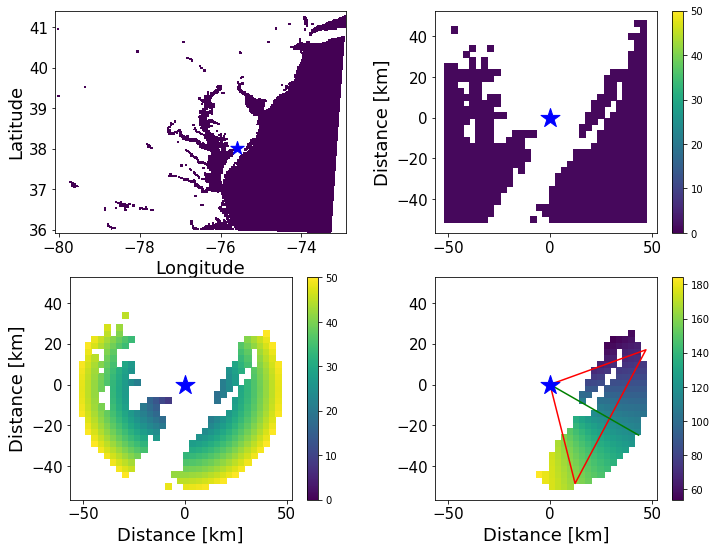

NameError: name 'wefwef' is not defined

In [60]:
# Maxiumum radius to look for water:
max_water_dist = 50.0

show_plots = False

window_len = int(max_water_dist/dx)*2
half_window_len = int(window_len/2)
window_center = int((window_len)/2)
window_dist = ((xy[:window_len+1,:window_len+1] - xy[window_center,window_center])**2 + 
               (yx[:window_len+1,:window_len+1] - yx[window_center,window_center])**2)**0.5
window_dist[np.where(window_dist > max_water_dist)] = np.nan
window_filter = window_dist / window_dist

window_x,window_y = np.meshgrid(np.arange(0,np.shape(window_dist)[1]+1)*dy - max_water_dist - 1.5,
                                np.arange(0,np.shape(window_dist)[0]+1)*dx - max_water_dist - 1.5)

window_deg = -1*(180.0*np.arctan(((yx[:window_len+1,:window_len+1] - yx[window_center,window_center])/
                     (xy[:window_len+1,:window_len+1] - xy[window_center,window_center])))/(np.pi) - 90.0)
window_deg[:,:half_window_len] = window_deg[:,:half_window_len] + 180.0
window_deg[np.where(np.isnan(window_dist))] = np.nan

math_deg = 180.0*np.arctan(((yx[:window_len+1,:window_len+1] - yx[window_center,window_center])/
                     (xy[:window_len+1,:window_len+1] - xy[window_center,window_center])))/(np.pi)
math_deg[:,:half_window_len] = math_deg[:,:half_window_len] + 180.0
math_deg[:half_window_len,half_window_len:] = 360 + math_deg[:half_window_len,half_window_len:]
math_deg[np.where(np.isnan(window_dist))] = np.nan


#onshore_min = np.zeros((ny,nx))*np.nan
#onshore_max = np.zeros((ny,nx))*np.nan
#for ii in np.arange(half_window_len,nx-half_window_len):
#    for jj in np.arange(half_window_len,ny-half_window_len): 
for ii in np.arange(128,nx-half_window_len): #98
    #for jj in np.arange(110,ny-half_window_len): 
    for jj in np.arange(75,ny-half_window_len): #87
        if land_mask[jj,ii] == 1.0:
            loc_water_mask = water_mask[jj-half_window_len:jj+half_window_len+1, ii-half_window_len:ii+half_window_len+1]
            dist_water = loc_water_mask * window_dist
            deg_water  = loc_water_mask * window_deg

            water_bodies = skimage.morphology.label(~np.isnan(deg_water)).astype(np.float32)
            water_bodies[water_bodies==0.0] = np.nan
            water_body_size = {}
            water_body_dist = {}
            min_water_distance = 999.9
            closest_water_body = 0.0
            if ~np.all(np.isnan(water_bodies)):
                for i in np.arange(1.0,np.nanmax(water_bodies)+1.0):
                    water_size = len(water_bodies[water_bodies==i])
                    if water_size < 8: 
                        water_bodies[water_bodies==i] = np.nan
                    else:
                        water_body_size[i] = water_size
                        water_body = water_bodies.copy()
                        water_body[water_bodies!=i] = np.nan
                        water_body[~np.isnan(water_body)] = 1.0
                        water_body_min_dist = np.nanpercentile(water_body*dist_water,50)
                        water_body_dist[i] = water_body_min_dist



                if ~np.all(np.isnan(water_bodies)):
                    largest_water_body = max(water_body_size,key=water_body_size.get)
                    closest_water_body = min(water_body_dist,key=water_body_size.get)
                    if largest_water_body == closest_water_body:
                        water_body_id = largest_water_body
                    else:
                        size_of_closest = water_body_size[closest_water_body]
                        dist_of_closest = water_body_dist[closest_water_body]
                        size_of_largest = water_body_size[largest_water_body]
                        dist_of_largest = water_body_dist[largest_water_body]
                        if (size_of_closest/size_of_largest) < 0.90:
                            water_body_id = largest_water_body
                        else:
                            water_body_id = closest_water_body
                        
                        
                    for i in np.arange(np.nanmin(water_bodies),np.nanmax(water_bodies)+1.0):
                        
                        if i != water_body_id:
                            water_bodies[water_bodies==i] = np.nan
                    water_bodies[water_bodies==water_body_id] = 1.0

                    deg_water *= water_bodies

                    deg_range = float(np.nanmax(deg_water)) - float(np.nanmin(deg_water))
                    if deg_range > 300:
                        deg_water[np.where(deg_water>300)] -= 360.0
                    # Set limits for upper and lower bounds.
                    # If range is too big (> max_deg_range) then we iterate by 5 degrees
                    # ... on the upper and lower limits until the range is sufficient.
                    if np.nanmax(water_bodies) > 0:
                        good_lims = False
                        low_pct = 90.0
                        upr_pct = 10.0
                        max_deg_range = 150.0
                        while good_lims == False:
                            lowr_lim = np.nanpercentile(deg_water,low_pct)
                            uppr_lim = np.nanpercentile(deg_water,upr_pct)
                            if lowr_lim - uppr_lim < max_deg_range:
                                good_lims = True
                            else:
                                low_pct -= 5.0
                                upr_pct += 5.0                                
                    else: # Set ones where water_bodies is all nan to nan
                        lowr_lim = np.nan
                        uppr_lim = np.nan
                    onshore_min[jj,ii] = uppr_lim 
                    onshore_max[jj,ii] = lowr_lim


                #'''
                lwr_xe = max_water_dist*np.cos(np.radians(convert_met_to_math(lowr_lim)))
                lwr_ye = max_water_dist*np.sin(np.radians(convert_met_to_math(lowr_lim)))
                upr_xe = max_water_dist*np.cos(np.radians(convert_met_to_math(uppr_lim)))
                upr_ye = max_water_dist*np.sin(np.radians(convert_met_to_math(uppr_lim)))

                mid_xe = max_water_dist*np.cos(np.radians(convert_met_to_math(np.nanmedian(deg_water))))
                mid_ye = max_water_dist*np.sin(np.radians(convert_met_to_math(np.nanmedian(deg_water))))

                fig = plt.figure(figsize=(12,9))
                lm_pltF = plt.subplot2grid((2,2),(0,0),aspect='equal')
                plt_landmask = lm_pltF.pcolormesh(lon,lat,land_mask.where(land_mask==0.0))#,levels=[0.5],colors='k')
                lm_pltF.scatter(lon[jj,ii],lat[jj,ii],facecolor='b',marker='*',s=200)
                lm_pltF.tick_params(labelsize=15)
                lm_pltF.set_xlabel('Longitude',size=18)
                lm_pltF.set_ylabel('Latitude',size=18)
                
                lm_plt = plt.subplot2grid((2,2),(0,1),aspect='equal')
                plt_landmask = lm_plt.pcolormesh(window_x,window_y,loc_water_mask,norm=Normalize(0,max_water_dist))
                plt.colorbar(plt_landmask,ax=lm_plt)
                lm_plt.scatter(0,0,facecolor='b',marker='*',s=400)
                lm_plt.set_xlim(np.nanmin(window_x)-5.0,np.nanmax(window_x)+5.0)
                lm_plt.set_ylim(np.nanmin(window_y)-5.0,np.nanmax(window_y)+5.0)
                lm_plt.tick_params(labelsize=15)
                lm_plt.set_ylabel('Distance [km]',size=18)
                
                dist_plt = plt.subplot2grid((2,2),(1,0),aspect='equal')
                dist_plt_cm = dist_plt.pcolormesh(window_x,window_y,dist_water,norm=Normalize(0,max_water_dist))             
                plt.colorbar(dist_plt_cm,ax=dist_plt)
                dist_plt.scatter(0,0,facecolor='b',marker='*',s=400)
                dist_plt.set_xlim(np.nanmin(window_x)-5.0,np.nanmax(window_x)+5.0)
                dist_plt.set_ylim(np.nanmin(window_y)-5.0,np.nanmax(window_y)+5.0)
                dist_plt.tick_params(labelsize=15)
                dist_plt.set_xlabel('Distance [km]',size=18)
                dist_plt.set_ylabel('Distance [km]',size=18)
                
                deg_plt = plt.subplot2grid((2,2),(1,1),aspect='equal')
                deg_plt_cm = deg_plt.pcolormesh(window_x,window_y,deg_water)#,norm=Normalize(0,360))
                plt.colorbar(deg_plt_cm,ax=deg_plt)
                deg_plt.plot([0,lwr_xe,upr_xe,0],[0,lwr_ye,upr_ye,0],c='r')
                deg_plt.plot([0,mid_xe],[0,mid_ye],c='g')
                deg_plt.scatter(0,0,facecolor='b',marker='*',s=400,zorder=5)
                ##ax[0].plot([0,upr_xe],[0,upr_ye],c='r')
                #deg_plt = ax[1].pcolormesh(window_x,window_y,deg_water)#,norm=Normalize(0,360))
                #plt.colorbar(deg_plt,ax=ax[1])
                deg_plt.set_xlim(np.nanmin(window_x)-5.0,np.nanmax(window_x)+5.0)
                deg_plt.set_ylim(np.nanmin(window_y)-5.0,np.nanmax(window_y)+5.0)
                deg_plt.tick_params(labelsize=15)
                deg_plt.set_xlabel('Distance [km]',size=18)
                plt.show()
                wefwef
                #'''

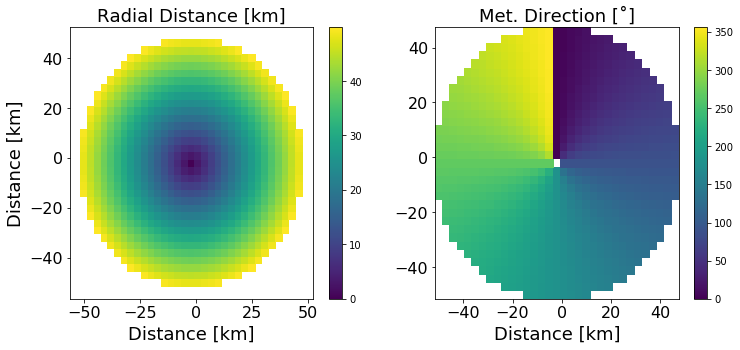

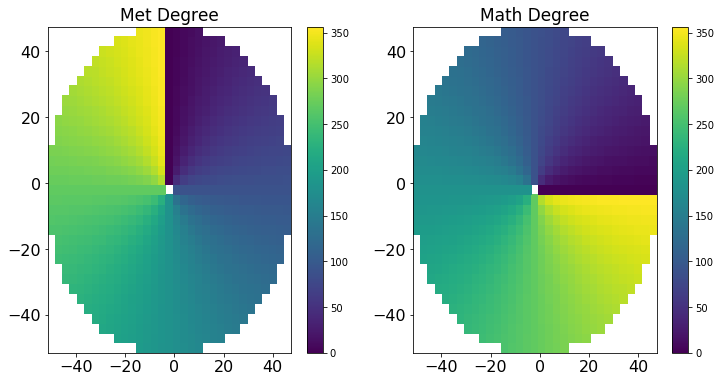

In [23]:
fig,ax = plt.subplots(ncols=2,figsize=(12,5))
dist_plt = ax[0].pcolormesh(window_x,window_y,window_dist)
plt.colorbar(dist_plt,ax=ax[0])
ax[0].set_xlim(np.min(window_x)-5,np.max(window_x)+5)
ax[0].set_ylim(np.min(window_y)-5,np.max(window_y)+5)
deg_plt = ax[1].pcolormesh(window_x,window_y,window_deg)
plt.colorbar(deg_plt,ax=ax[1])
ax[0].tick_params(labelsize=16)
ax[0].set_title('Radial Distance [km]',size=18)
ax[0].set_xlabel('Distance [km]',size=18)
ax[0].set_ylabel('Distance [km]',size=18)
ax[1].tick_params(labelsize=16)
ax[1].set_title('Met. Direction [˚]',size=18)
ax[1].set_xlabel('Distance [km]',size=18)
plt.show()




fig,ax = plt.subplots(ncols=2,figsize=(12,6))
dist_plt = ax[0].pcolormesh(window_x,window_y,window_deg)
plt.colorbar(dist_plt,ax=ax[0])
ax[0].set_title('Met Degree',size=17)
deg_plt = ax[1].pcolormesh(window_x,window_y,math_deg)
plt.colorbar(deg_plt,ax=ax[1])
ax[1].set_title('Math Degree',size=17)
ax[0].tick_params(labelsize=16)
ax[1].tick_params(labelsize=16)
plt.show()


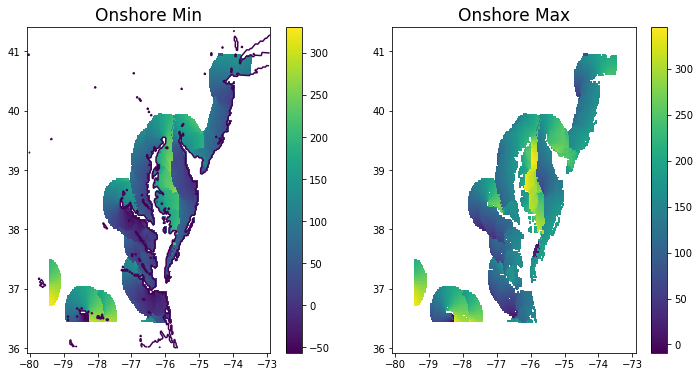

In [9]:
fig,ax = plt.subplots(ncols=2,figsize=(12,6))
dist_plt = ax[0].pcolormesh(lon,lat,onshore_min)
plt.colorbar(dist_plt,ax=ax[0])
ax[0].contour(lon,lat,land_mask,levels=[0.5])
ax[0].set_title('Onshore Min',size=17)
deg_plt = ax[1].pcolormesh(lon,lat,onshore_max)
plt.colorbar(deg_plt,ax=ax[1])
ax[1].set_title('Onshore Max',size=17)
plt.show()

# Check onshore min/max with what was determined in previous study:

Station: APG
	Onshore min - Old: 50.000	New: 90.000
	Onshore max - Old: 200.000	New: 213.690
Station: BWI
	Onshore min - Old: 60.000	New: 63.435
	Onshore max - Old: 160.000	New: 151.034
Station: MTN
	Onshore min - Old: 70.000	New: 64.495
	Onshore max - Old: 190.000	New: 180.000
Station: NAK
	Onshore min - Old: 20.000	New: 26.565
	Onshore max - Old: 190.000	New: 172.084
Station: NHK
	Onshore min - Old: -10.000	New: 28.678
	Onshore max - Old: 170.000	New: 157.091
Station: NUI
	Onshore min - Old: 0.000	New: 45.000
	Onshore max - Old: 150.000	New: 158.962


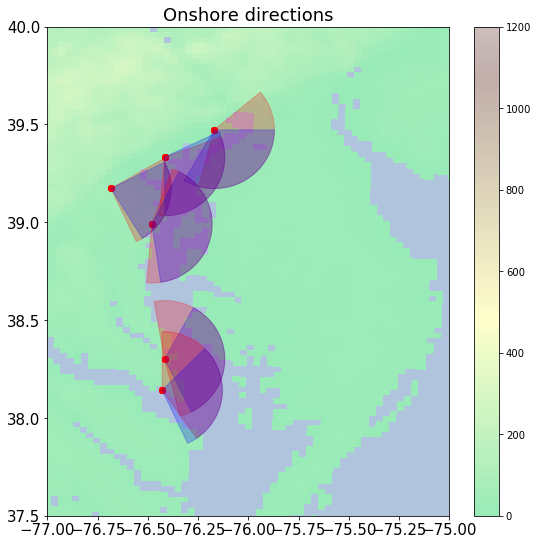

In [10]:
fig = plt.figure(figsize=(9,9))
hgt = hgt.where(land_mask == 1.0)
#hgt[np.where(land_mask==0.0)] = -100
plt.pcolormesh(lon,lat,hgt,
               cmap=light_cmap,
               norm=Normalize(0,1200))
plt.colorbar()
plt.tick_params(labelsize=15)
plt.title('Onshore directions',size=18)

for ss,stn in enumerate(near_shore_stations):
    #if stn == 'APG':
    #    stn_ds = apg_ds.sel(station=stn)
    if stn in awos_ds.station:
        stn_ds = awos_ds.sel(station=stn)
    elif stn in asos_ds.station:
        stn_ds = asos_ds.sel(station=stn)
    stn_lat = stn_ds.lat.data
    stn_lon = stn_ds.lon.data
    dist_from_stn = ((lon-stn_lon)**2 + (lat-stn_lat)**2)**0.5
    stn_j,stn_i = np.where(dist_from_stn == np.nanmin(dist_from_stn))
    stn_j = int(stn_j)
    stn_i = int(stn_i)
    print('Station: {}'.format(stn))
    print('\tOnshore min - Old: {0:4.3f}\tNew: {1:4.3f}'.format(stn_ds.onshore_min.data,onshore_min[stn_j,stn_i]))
    print('\tOnshore max - Old: {0:4.3f}\tNew: {1:4.3f}'.format(stn_ds.onshore_max.data,onshore_max[stn_j,stn_i]))
    

    x, y = stn_lon,stn_lat
    plt.scatter(x,y,c='r')
    for rad in ['old','new']:
        if rad == 'old':
            pts  = np.arange(stn_ds.onshore_min.data,stn_ds.onshore_max.data,5.0)
            fill_c = 'r'
        else:
            pts  = np.arange(onshore_min[stn_j,stn_i],onshore_max[stn_j,stn_i],5.0)
            fill_c = 'b'
            
        npts = pts.size
        fill_x = [x]
        fill_y = [y]
        plt.scatter(x,y,c='r')
        for dd,wdir in enumerate(pts):
            d = 270.0 - wdir    # Convert met degrees to polar
            plt_dist = -0.3 # Met degrees are FROM dir... need negative distance!
            fill_x.append(x+plt_dist*np.cos(np.radians(d)))
            fill_y.append(y+plt_dist*np.sin(np.radians(d)))

        plt.fill(fill_x, fill_y,alpha=0.25,lw=None,color=fill_c,zorder=2)
        plt.text
plt.xlim(-77.0,-75.0)
plt.ylim(37.5,40.0)
plt.show()

In [12]:
onshore_winds = dir10.where((dir10 >= onshore_min) & (dir10 <= onshore_max))
#onshore_winds /= onshore_winds
onshore_winds = onshore_winds.fillna(0.0)

In [13]:
#dT = np.zeros((ny,nx))*np.nan
dT = t2.where(~np.isnan(onshore_min))
dU = vel10.where(~np.isnan(onshore_min))

for ii in np.arange(1,nx-1):
    for jj in np.arange(1,ny-1):
        if ~np.isnan(dT[jj,ii]):
            T_window = t2[jj-1:jj+2,ii-1:ii+2].data.flatten()
            dT_window = t2[jj,ii].data - T_window
            dT_window[np.where(dT_window>=0.0)] = np.nan
            if np.count_nonzero(np.isnan(dT_window)) > 8:
                dT[jj,ii] = np.nan
            else:
                dT[jj,ii] = np.nanmean(dT_window)
                
        if ~np.isnan(dU[jj,ii]):
            U_window = vel10[jj-1:jj+2,ii-1:ii+2].data.flatten()
            dU_window = vel10[jj,ii].data - U_window
            dU_window[np.where(dU_window<=0.0)] = np.nan
            if np.count_nonzero(np.isnan(dU_window)) > 8:
                dU[jj,ii] = np.nan
            else:
                dU[jj,ii] = np.nanmean(dU_window)

dT = np.abs(dT)
dU = np.abs(dU)


/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal


In [14]:
var_dict = {'onshore min':onshore_min,
             't2':t2,
             'dT':dT,
             'dU':dU,
            'dir':dir10,
            'vel':vel10,
           'sfcP':sfcP,
            }

#var_dict = { 't2':t2,
#            'dTx':dTx,
#            'dTy':dTy,
#             'dT':dT
#           }

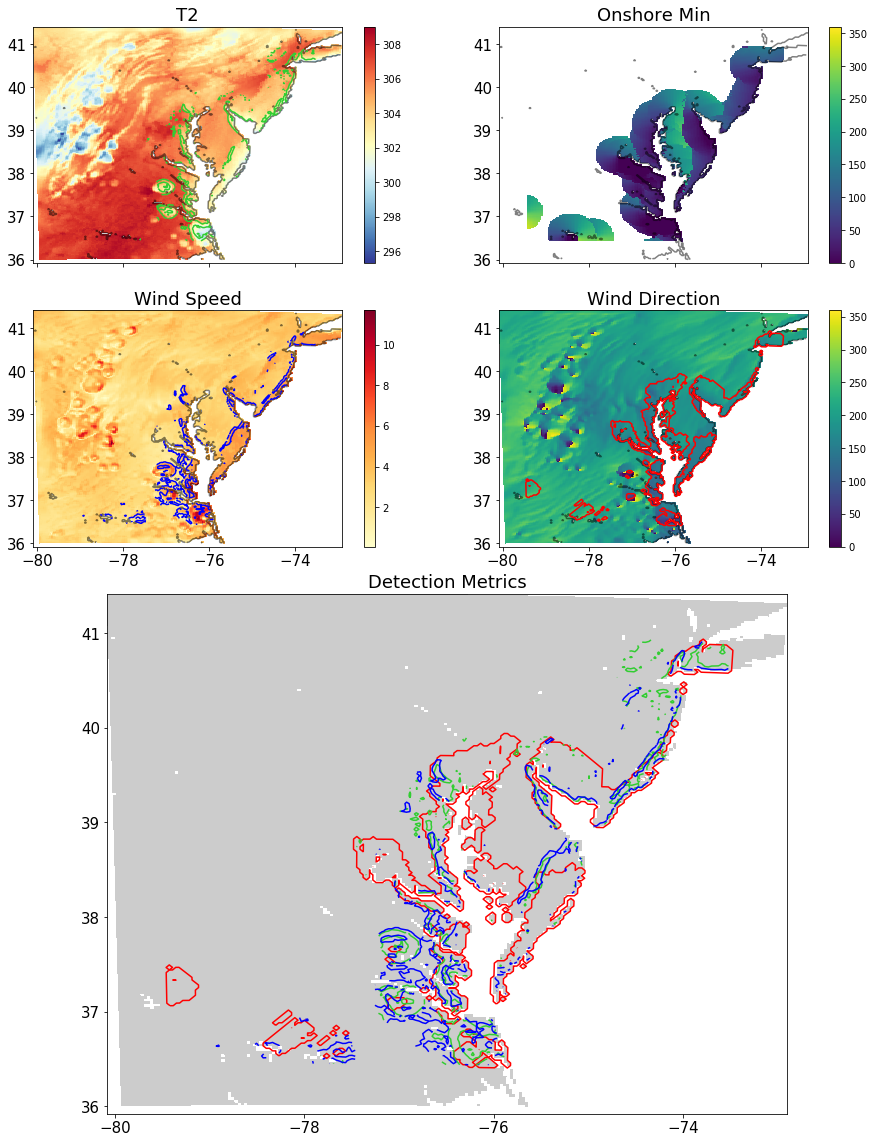

In [15]:
fig = plt.figure(figsize=(16,20))
nrow,ncol = 4,4
tmp_plt = plt.subplot2grid((nrow,ncol),(0,0),colspan=2,aspect='equal')
tmp_plt_pc = tmp_plt.pcolormesh(lon,lat,t2,cmap=plt.cm.RdYlBu_r)
plt.colorbar(tmp_plt_pc,ax=tmp_plt)
tmp_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
tmp_plt.contour(lon,lat,dT,levels=[0.5],colors='limegreen')
tmp_plt.tick_params(labelsize=15,labelbottom=False)
tmp_plt.set_title('T2',size=18)


vel_plt = plt.subplot2grid((nrow,ncol),(1,0),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
vel_plt_pc = vel_plt.pcolormesh(lon,lat,vel10,cmap=plt.cm.YlOrRd)
plt.colorbar(vel_plt_pc,ax=vel_plt)
vel_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
vel_plt.contour(lon,lat,dU,levels=[0.5],colors='b')
vel_plt.tick_params(labelsize=15)
vel_plt.set_title('Wind Speed',size=18)

ons_plt = plt.subplot2grid((nrow,ncol),(0,2),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
ons_plt_pc = ons_plt.pcolormesh(lon,lat,onshore_min,cmap=plt.cm.viridis,norm=Normalize(0,360))
plt.colorbar(ons_plt_pc,ax=ons_plt)
ons_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
ons_plt.tick_params(labelsize=15,labelbottom=False)
ons_plt.set_title('Onshore Min',size=18)

dir_plt = plt.subplot2grid((nrow,ncol),(1,2),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
dir_plt_pc = dir_plt.pcolormesh(lon,lat,dir10,cmap=plt.cm.viridis,norm=Normalize(0,360))
plt.colorbar(dir_plt_pc,ax=dir_plt)
dir_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
dir_plt.contour(lon,lat,onshore_winds,levels=[1.0],colors='r')
dir_plt.tick_params(labelsize=15)
dir_plt.set_title('Wind Direction',size=18)


crt_plt = plt.subplot2grid((nrow,ncol),(2,0),rowspan=2,colspan=4,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
crt_plt_pc = crt_plt.pcolormesh(lon,lat,land_mask,cmap=plt.cm.binary,norm=Normalize(0,5.0))
#plt.colorbar(crt_plt_pc,ax=crt_plt)
crt_plt.contour(lon,lat,onshore_winds,levels=[1.0],colors='r')
crt_plt.contour(lon,lat,dT,levels=[0.5],colors='limegreen')
crt_plt.contour(lon,lat,dU,levels=[0.5],colors='b')
crt_plt.tick_params(labelsize=15)
crt_plt.set_title('Detection Metrics',size=18)
plt.show()